In [ ]:
!pip install imbalanced-learn --quiet

In [ ]:
hoimport pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [ ]:
df_train = pd.read_csv("/content/df_train_clean.csv")
df_dev   = pd.read_csv("/content/df_dev_clean.csv")
df_test  = pd.read_csv("/content/df_test_clean.csv")

In [ ]:
for df in (df_train, df_dev, df_test):
    df['content'] = df['content'].fillna('').astype(str)

In [ ]:
X_train, y_train = df_train["content"].fillna("").tolist(), df_train["label"].tolist()
X_dev,   y_dev   = df_dev["content"].fillna("").tolist(),   df_dev["label"].tolist()
X_test,  y_test  = df_test["content"].fillna("").tolist(),  df_test["label"].tolist()

In [ ]:
emo_df = pd.read_excel("VnEmoLex.xlsx", sheet_name=0)
drop_cols = [c for c in emo_df.columns if "Unnamed" in c]
emo_df.drop(columns=drop_cols, inplace=True)

In [ ]:
lex = emo_df[["Vietnamese","Positive","Negative"]].rename(columns={"Vietnamese":"word"})
words, pos_flag, neg_flag = lex["word"], lex["Positive"], lex["Negative"]

In [ ]:
lex_dict = {
    0: set(words[neg_flag==1]),               # negative
    1: set(words[(neg_flag==0)&(pos_flag==0)]), # neutral
    2: set(words[pos_flag==1])                # positive
}
class_labels = ["neg","neu","pos"]

In [ ]:
class VnEmoLexiconCounts(BaseEstimator, TransformerMixin):
    def __init__(self, lexicon_dict):
        self.lex = lexicon_dict
        self.labels = sorted(lexicon_dict.keys())
    def fit(self, X, y=None): return self
    def transform(self, X):
        feats = []
        for doc in X:
            ws = doc.lower().split()
            counts = [sum(1 for w in ws if w in self.lex[lbl]) for lbl in self.labels]
            feats.append(counts)
        return np.array(feats, dtype=np.float32)

In [ ]:
word_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.8)
char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=5)
tfidf_union= FeatureUnion([("w",word_vect),("c",char_vect)])
vnelex     = VnEmoLexiconCounts(lex_dict)

In [ ]:
full_features = FeatureUnion([
    ("tfidf", tfidf_union),
    ("vnemolex", vnelex)
])

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
base_models = {
    "SVM (linear)"       : SVC(kernel="linear", C=1, class_weight="balanced", probability=True, random_state=42),
    "LogisticRegression" : LogisticRegression(C=1, max_iter=1000, class_weight="balanced", random_state=42),
    "RandomForest"       : RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree"       : DecisionTreeClassifier(random_state=42),
    "NaiveBayes"         : MultinomialNB()
}

In [ ]:
pipelines = {
    name: ImbPipeline([
        ('features', full_features),
        ('smote',    smote),
        ('clf',      model),
    ])
    for name, model in base_models.items()
}

In [ ]:
def evaluate_model(pipe, X, y, split_name, model_name, class_labels):
    y_pred = pipe.predict(X)
    print(f"\n--- {model_name} on {split_name} ---")
    print(classification_report(
        y, y_pred,
        labels=[0,1,2],
        target_names=class_labels,
        zero_division=0,
        digits=4
    ))
    cm = confusion_matrix(y, y_pred, labels=[0,1,2])
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix ({split_name})")
    plt.colorbar()
    ticks = np.arange(len(class_labels))
    plt.xticks(ticks, class_labels, rotation=45)
    plt.yticks(ticks, class_labels)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color=color)

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


======== Training SVM (linear) ========

--- SVM (linear) on Train ---
              precision    recall  f1-score   support

         neg     0.9791    0.9874    0.9833      5325
         neu     0.8774    1.0000    0.9347       458
         pos     0.9926    0.9734    0.9829      5643

    accuracy                         0.9810     11426
   macro avg     0.9497    0.9869    0.9670     11426
weighted avg     0.9817    0.9810    0.9811     11426



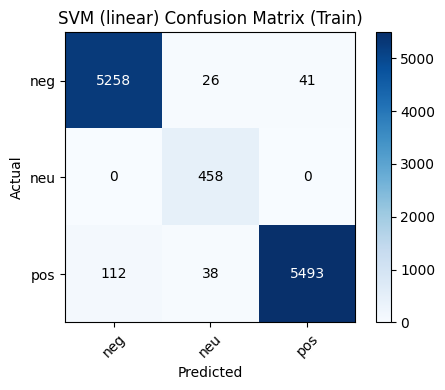


--- SVM (linear) on Dev ---
              precision    recall  f1-score   support

         neg     0.9102    0.9206    0.9154       705
         neu     0.4416    0.4658    0.4533        73
         pos     0.9382    0.9242    0.9312       805

    accuracy                         0.9015      1583
   macro avg     0.7633    0.7702    0.7666      1583
weighted avg     0.9028    0.9015    0.9021      1583



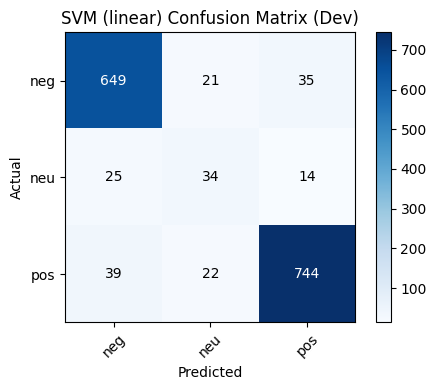


--- SVM (linear) on Test ---
              precision    recall  f1-score   support

         neg     0.8810    0.9248    0.9024      1409
         neu     0.4074    0.3293    0.3642       167
         pos     0.9278    0.9057    0.9166      1590

    accuracy                         0.8838      3166
   macro avg     0.7387    0.7199    0.7277      3166
weighted avg     0.8795    0.8838    0.8811      3166



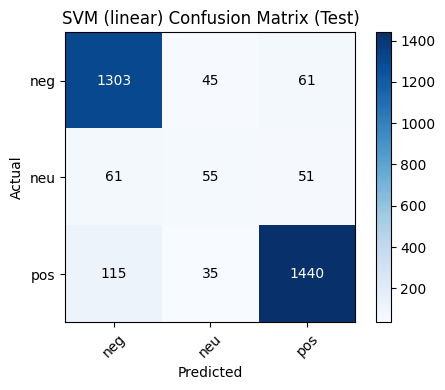


======== Training LogisticRegression ========

--- LogisticRegression on Train ---
              precision    recall  f1-score   support

         neg     0.9659    0.9671    0.9665      5325
         neu     0.6828    0.9869    0.8071       458
         pos     0.9869    0.9500    0.9681      5643

    accuracy                         0.9595     11426
   macro avg     0.8785    0.9680    0.9139     11426
weighted avg     0.9649    0.9595    0.9609     11426



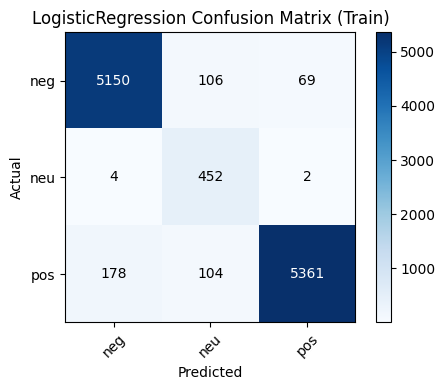


--- LogisticRegression on Dev ---
              precision    recall  f1-score   support

         neg     0.9149    0.8993    0.9070       705
         neu     0.3661    0.5616    0.4432        73
         pos     0.9409    0.9093    0.9248       805

    accuracy                         0.8888      1583
   macro avg     0.7406    0.7901    0.7584      1583
weighted avg     0.9028    0.8888    0.8947      1583



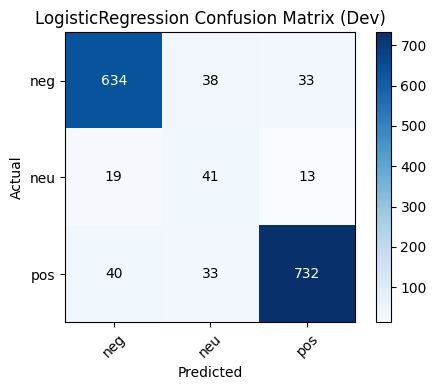


--- LogisticRegression on Test ---
              precision    recall  f1-score   support

         neg     0.8927    0.9155    0.9040      1409
         neu     0.3935    0.5090    0.4439       167
         pos     0.9435    0.8931    0.9176      1590

    accuracy                         0.8828      3166
   macro avg     0.7433    0.7725    0.7552      3166
weighted avg     0.8919    0.8828    0.8866      3166



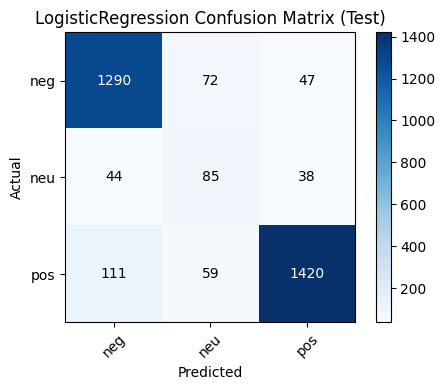


======== Training RandomForest ========

--- RandomForest on Train ---
              precision    recall  f1-score   support

         neg     0.9998    1.0000    0.9999      5325
         neu     0.9978    1.0000    0.9989       458
         pos     1.0000    0.9996    0.9998      5643

    accuracy                         0.9998     11426
   macro avg     0.9992    0.9999    0.9995     11426
weighted avg     0.9998    0.9998    0.9998     11426



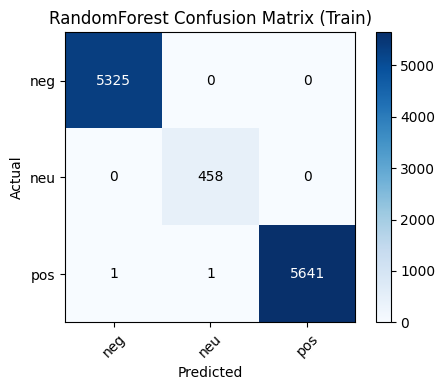


--- RandomForest on Dev ---
              precision    recall  f1-score   support

         neg     0.8722    0.9291    0.8997       705
         neu     0.5800    0.3973    0.4715        73
         pos     0.9246    0.8981    0.9112       805

    accuracy                         0.8888      1583
   macro avg     0.7922    0.7415    0.7608      1583
weighted avg     0.8853    0.8888    0.8858      1583



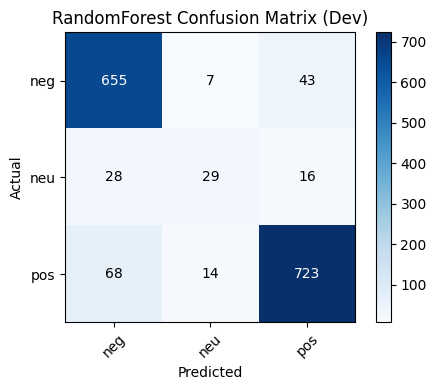


--- RandomForest on Test ---
              precision    recall  f1-score   support

         neg     0.8426    0.9383    0.8878      1409
         neu     0.5340    0.3293    0.4074       167
         pos     0.9250    0.8692    0.8962      1590

    accuracy                         0.8714      3166
   macro avg     0.7672    0.7123    0.7305      3166
weighted avg     0.8677    0.8714    0.8667      3166



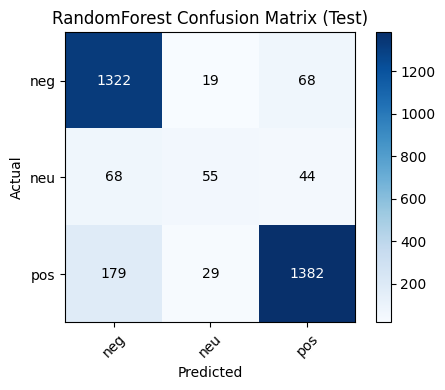


======== Training DecisionTree ========

--- DecisionTree on Train ---
              precision    recall  f1-score   support

         neg     0.9998    1.0000    0.9999      5325
         neu     0.9978    1.0000    0.9989       458
         pos     1.0000    0.9996    0.9998      5643

    accuracy                         0.9998     11426
   macro avg     0.9992    0.9999    0.9995     11426
weighted avg     0.9998    0.9998    0.9998     11426



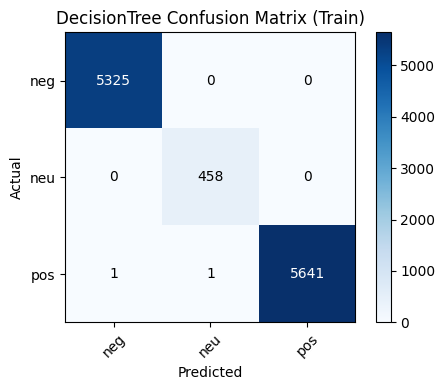


--- DecisionTree on Dev ---
              precision    recall  f1-score   support

         neg     0.8386    0.7887    0.8129       705
         neu     0.2824    0.3288    0.3038        73
         pos     0.8383    0.8696    0.8537       805

    accuracy                         0.8086      1583
   macro avg     0.6531    0.6623    0.6568      1583
weighted avg     0.8128    0.8086    0.8101      1583



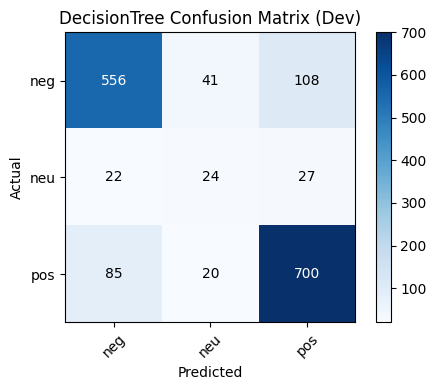


--- DecisionTree on Test ---
              precision    recall  f1-score   support

         neg     0.8121    0.7885    0.8001      1409
         neu     0.2475    0.2994    0.2710       167
         pos     0.8377    0.8409    0.8393      1590

    accuracy                         0.7890      3166
   macro avg     0.6325    0.6429    0.6368      3166
weighted avg     0.7952    0.7890    0.7919      3166



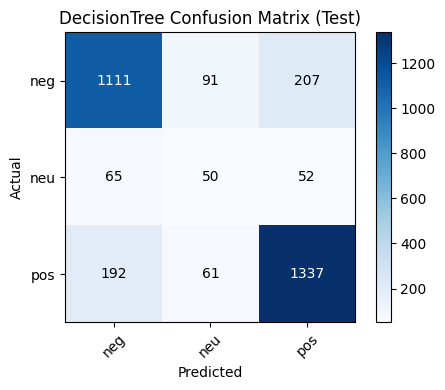


======== Training NaiveBayes ========

--- NaiveBayes on Train ---
              precision    recall  f1-score   support

         neg     0.8804    0.8973    0.8888      5325
         neu     0.3904    0.8515    0.5353       458
         pos     0.9540    0.8453    0.8964      5643

    accuracy                         0.8698     11426
   macro avg     0.7416    0.8647    0.7735     11426
weighted avg     0.8971    0.8698    0.8784     11426



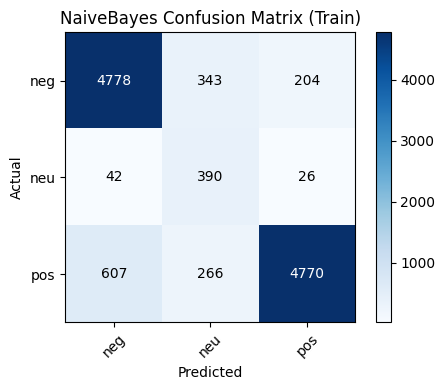


--- NaiveBayes on Dev ---
              precision    recall  f1-score   support

         neg     0.8603    0.8823    0.8711       705
         neu     0.3033    0.5068    0.3795        73
         pos     0.9295    0.8522    0.8892       805

    accuracy                         0.8497      1583
   macro avg     0.6977    0.7471    0.7133      1583
weighted avg     0.8698    0.8497    0.8576      1583



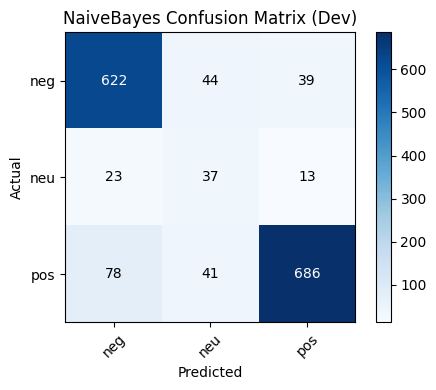


--- NaiveBayes on Test ---
              precision    recall  f1-score   support

         neg     0.8208    0.8744    0.8467      1409
         neu     0.2769    0.4311    0.3372       167
         pos     0.9331    0.8245    0.8755      1590

    accuracy                         0.8260      3166
   macro avg     0.6769    0.7100    0.6865      3166
weighted avg     0.8485    0.8260    0.8343      3166



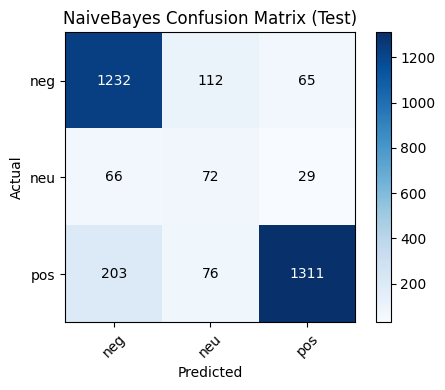

In [ ]:
for name, pipe in pipelines.items():
    print(f"\n======== Training {name} ========")
    pipe.fit(X_train, y_train)
    for split_name, (X_split, y_split) in [
        ("Train", (X_train, y_train)),
        ("Dev",   (X_dev,   y_dev)),
        ("Test",  (X_test,  y_test)),
    ]:
        evaluate_model(pipe, X_split, y_split, split_name, name, class_labels)
